# DE Portfolio 9: Time Series Part II

This model uses the GTD (Global Terrorism Dataset) data. The dataset includes records of terrorist incidents and events starting 1970, including details such as targets, weapons, terrorist organizations or number of kills. The goal is to forecst the number of terrorist attacks that will occur in the next 100 days globally. The data is filtered to focus on daily records of attacks from 2020 and 2021. While the dataset does not specifically provide a cont of attacks occuring at specifc dates, each attack recorded includes year, month and day. In order to forecast attacks, the counts are a result of date grouping. A second dataset was used for computing models with seasonality since GTD does not have that. The dataset shows Google stock prices per month, and the prediction taks focuses on forecasting the monthly closing price of Google's stock for an year.

GTD Dataset Source: [https://www.start.umd.edu/gtd/](https://www.start.umd.edu/gtd/)

Google Stock Dataset Source: [https://www.kaggle.com/datasets/alirezajavid1999/google-stock-2010-2023](https://www.kaggle.com/datasets/alirezajavid1999/google-stock-2010-2023)

In [1]:
import statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter 
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from tqdm import trange
warnings.filterwarnings("ignore")

# Set display option to avoid scientific notation in pandas, show up to 5 decimal points
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# and numpy
np.set_printoptions(suppress=True, precision=5)

### Load and Prepare Data

In [2]:
df=pd.read_csv('Data_All.csv')
display(df)

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,1_txt
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,PGIS,0,0,0,0,NaN,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214661,202106300023,2021,6,30,NaN,0,NaN,4,Afghanistan,6,...,"""Gunmen blow up power pylon in Parwan,"" Afghan...","""Provinces hit by blackout after power pylon d...",NaN,START Primary Collection,-9,-9,0,-9,NaN,Electricity
214662,202106300029,2021,6,30,06/30/2021,0,NaN,138,Myanmar,5,...,"""Spring Revolution Daily News for 16-30 June 2...",NaN,NaN,START Primary Collection,-9,-9,0,-9,NaN,Other Personnel
214663,202106300030,2021,6,30,NaN,1,2021-07-08,147,Nigeria,11,...,"""Boko Haram Releases Abducted Catholic Priest ...","""Kidnapped Maiduguri Catholic Priest regains f...","""ISWAP-Boko Haram Abduct Catholic Priest In Bo...",START Primary Collection,0,0,0,0,NaN,Religious Figure
214664,202106300038,2021,6,30,NaN,0,NaN,45,Colombia,3,...,"""Two dead and one wounded after clashes betwee...",NaN,NaN,START Primary Collection,0,0,0,0,NaN,NaN


In [3]:
#Select values from 2019
df=df[df['iyear']>=2019]
df = df[['eventid','iyear', 'imonth', 'iday']]
values_to_replace = ['Unknown', 'Other', -99, -9]
df.replace(values_to_replace, np.nan, inplace=True)
df=df.dropna()
display(df)


,eventid,iyear,imonth,iday
192717,201812310019,2019,1,2
192732,201901010002,2019,1,1
192733,201901010003,2019,1,1
192734,201901010004,2019,1,1
192735,201901010005,2019,1,1
...,...,...,...,...
214661,202106300023,2021,6,30
214662,202106300029,2021,6,30
214663,202106300030,2021,6,30
214664,202106300038,2021,6,30


In [4]:
#Filter dataframe to dates and attack numbers

#Slice eventid string to focus only on the dates and remove identification code (last 4 digits)
df['eventid'] = df['eventid'].astype(str).str[:8] 

#Convert eventid to datetime
df['eventid'] = pd.to_datetime(df['eventid'], format='%Y%m%d', errors='coerce')

#Count how many attacks occured by grouping them absed on same date
time_data = df.groupby('eventid').size().reset_index(name='number_attacks')

#Drop duplicates and nans
time_data = time_data[['eventid','number_attacks']].drop_duplicates()
time_data=time_data.dropna()
display(time_data)


,eventid,number_attacks
0,2018-12-31,1
1,2019-01-01,39
2,2019-01-02,15
3,2019-01-03,16
4,2019-01-04,23
...,...,...
910,2021-06-28,44
911,2021-06-29,35
912,2021-06-30,23
913,2021-07-02,1


#### Visualize Data

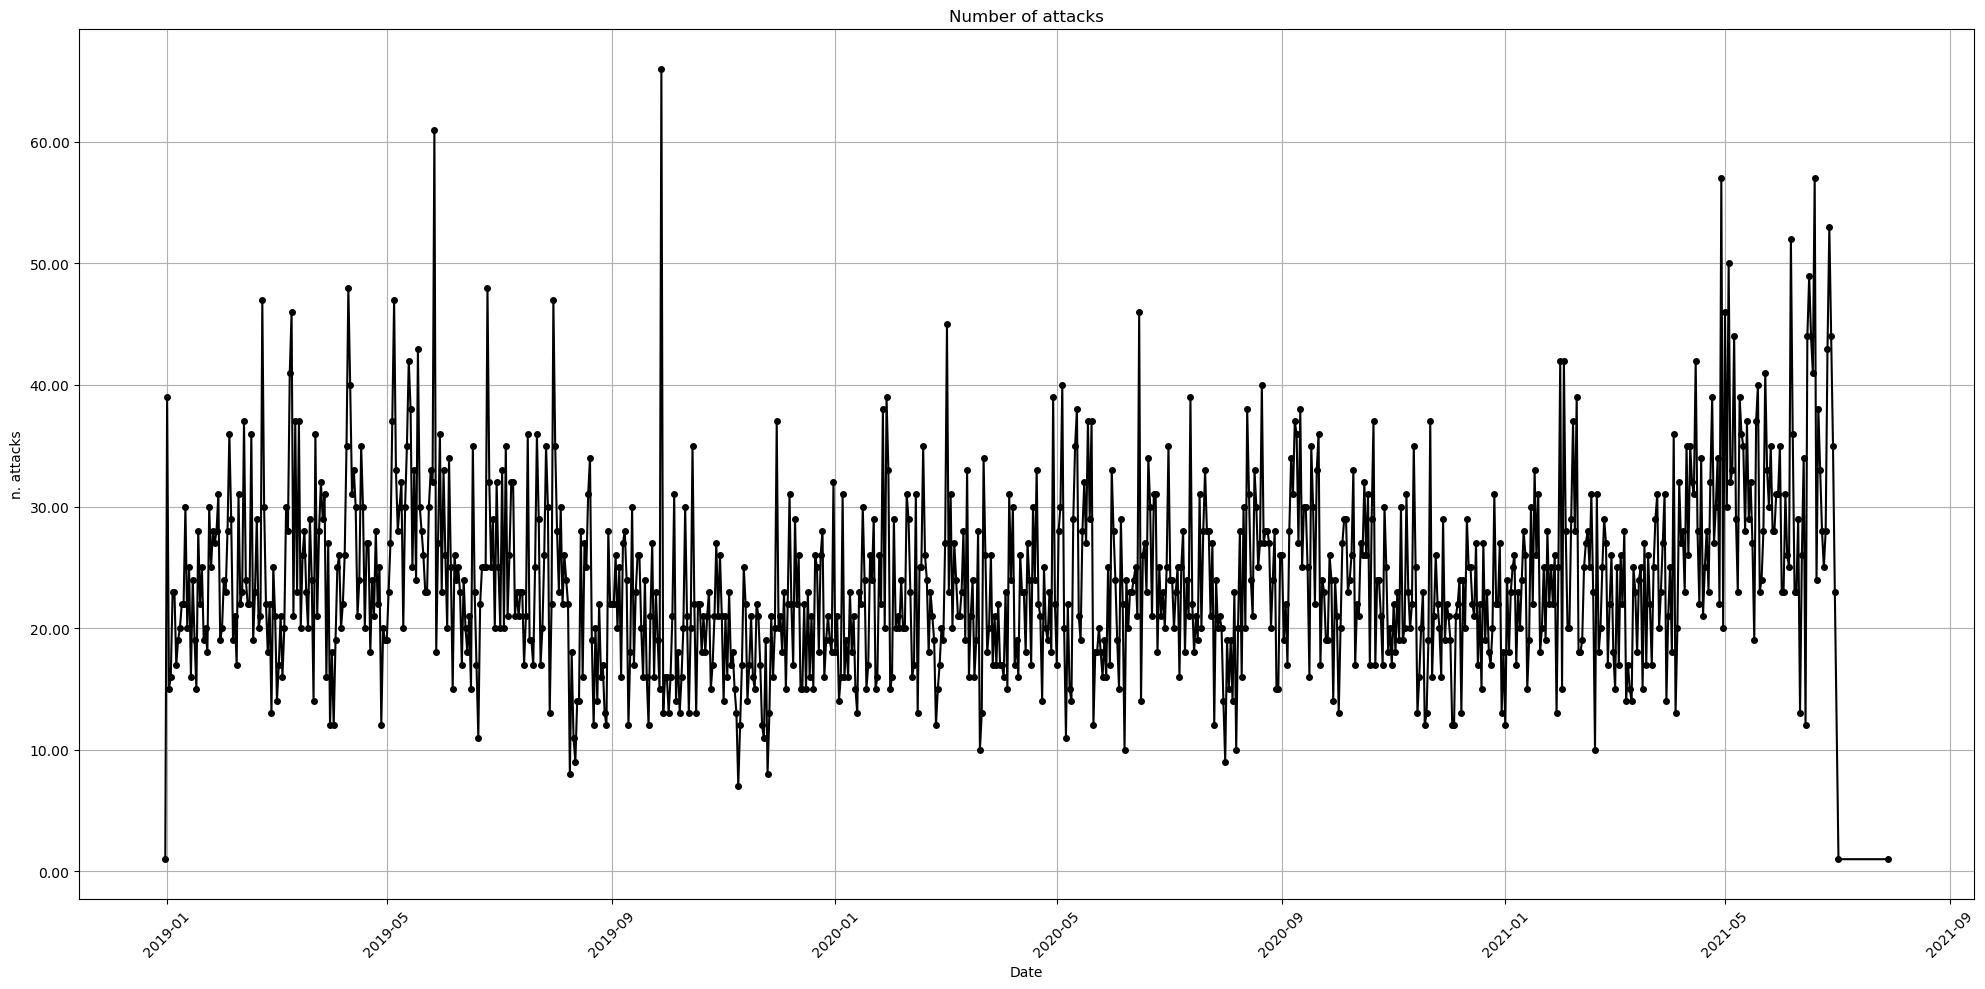

In [5]:
#Convert date to datetime format
df['eventid'] = pd.to_datetime(df['eventid'])

#Plot the data
plt.figure(figsize=(20, 10))
plt.plot(time_data['eventid'], time_data['number_attacks'], marker='o', linestyle='-', color='black',markersize = '4')
plt.title('Number of attacks')
plt.xlabel('Date')
plt.ylabel('n. attacks')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
#Additional check on whether the model is stationary with Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adf = adfuller(time_data['number_attacks'].dropna())

output = pd.Series(adf[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf[4].items():
    output[f'Critical Value ({key})'] = value

print(output)

Test Statistic                 -5.24634
p-value                         0.00001
#Lags Used                     12.00000
Number of Observations Used   902.00000
Critical Value (1%)            -3.43762
Critical Value (5%)            -2.86475
Critical Value (10%)           -2.56848
dtype: float64


The data seems to be stationary based on the plot visualization and Dickey-Fuller test. Therefore we do not have to work on the data in any ways and we can use the raw values for time series models.

<Figure size 1200x600 with 0 Axes>

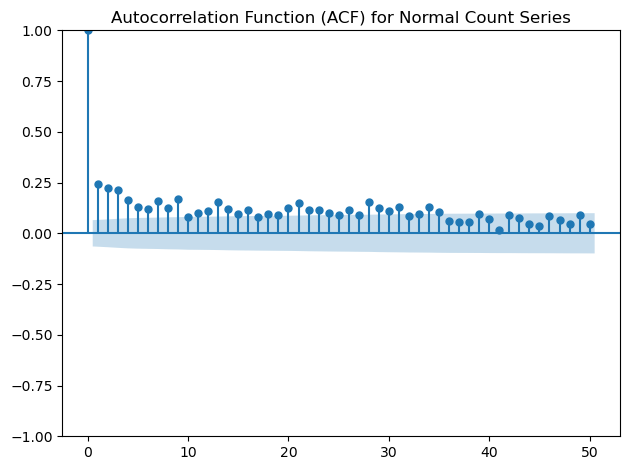

<Figure size 1200x600 with 0 Axes>

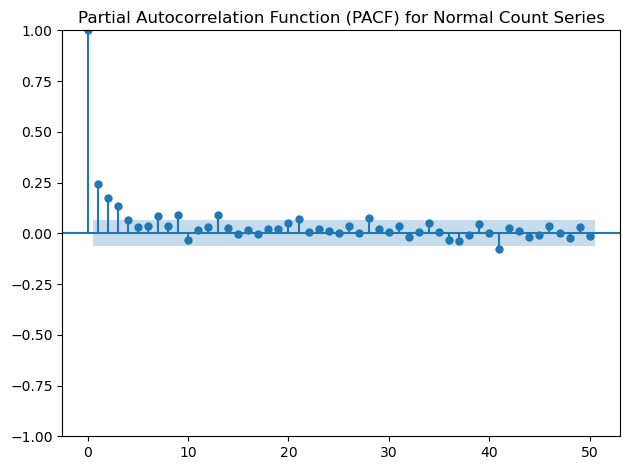

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(time_data['number_attacks'].dropna(), lags=50, alpha=0.05, title='Autocorrelation Function (ACF) for Normal Count Series')
plt.tight_layout()

# Plot Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(time_data['number_attacks'].dropna(), lags=50, alpha=0.05, title='Partial Autocorrelation Function (PACF) for Normal Count Series')
plt.tight_layout()

plt.show()

### Find and Fit Optimal Model

In [8]:
from pmdarima import auto_arima
import pandas as pd

time_series = time_data['number_attacks'].dropna()
time_series.index = pd.to_datetime(time_data['eventid'])  # Assuming 'series.index' contains date strings


#Find optimal model using auto arima
auto_model = auto_arima(time_series,
                        start_p=0, start_q=0,
                        max_p=20, max_q=20,  # Maximum p and q
                        seasonal=False,  # Enable search for seasonal parameters
                        test='adf',  # Use ADF test to find optimal 'd'
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8506.385, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6714.371, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=7792.612, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=6490.797, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=6403.522, Time=0.16 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=6374.458, Time=0.20 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=6266.480, Time=0.48 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=6268.233, Time=0.45 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=6268.442, Time=0.73 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=6270.091, Time=1.07 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.89 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=0.95 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=6275.650, Time=1.24 sec

Best model:  ARIMA(4,0,1)(0,0,0)[0]          
T

In [9]:
#Extract regular order
auto_order = auto_model.order

#Extract the seasonal order
seasonal_order = auto_model.seasonal_order

#Print orders
print(f"Non-seasonal order: {auto_order}")
print(f"Seasonal order: {seasonal_order}")

Non-seasonal order: (4, 0, 1)
Seasonal order: (0, 0, 0, 0)


In [10]:
#Split data into training and testing sets
train_size = int(len(time_series) * 0.95)
series_train, series_test = time_series[:train_size], time_series[train_size:]

historical_series = series_train.values.copy()

#Initialize empty lists for predictions and confidence intervals
predictions = []
confidence_intervals = []

#Rolling forecast origin
for t in trange(len(series_test)):
    #Fit the SARIMA model
    sarima = SARIMAX(historical_series, order=auto_order, seasonal_order=seasonal_order)
    model = sarima.fit(disp=False)
    
    #Get forecast results for the next step and confidence intervals
    forecasts = model.get_forecast(steps=1)
    yhat = forecasts.predicted_mean
    interval = forecasts.conf_int(alpha=0.05)  # 95% confidence interval
    
    predictions.append(yhat[0])
    confidence_intervals.append(interval[0])
    
    #Add the actual observation from test set to history for the next loop
    actual_obs = series_test.iloc[t]  #Access the observation
    historical_series = np.append(historical_series, actual_obs)

100%|██████████| 46/46 [00:23<00:00,  1.95it/s]


Test RMSE: 11.585165068928239


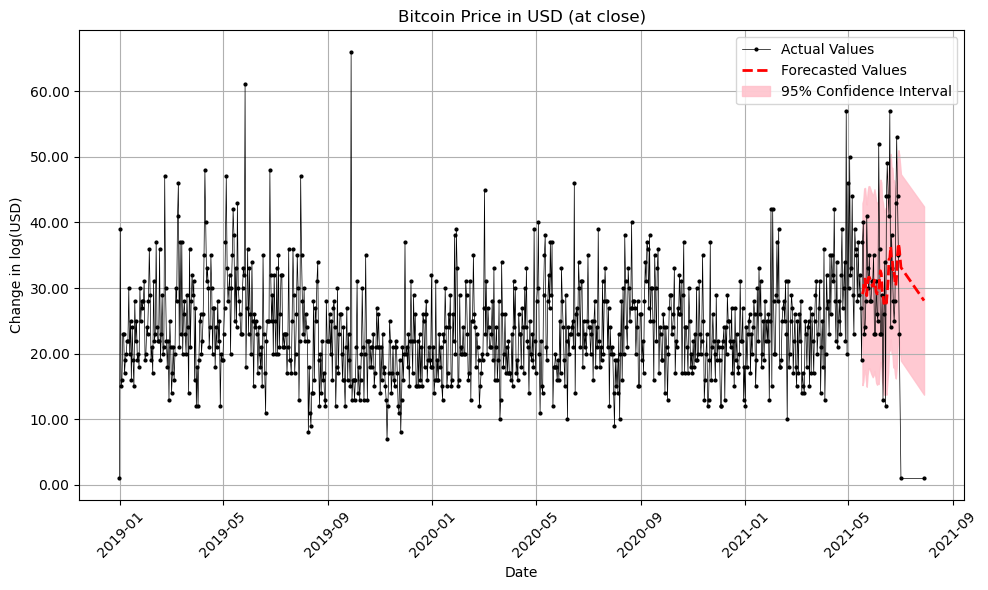

In [11]:
#Calculate RMSE
rmse = np.sqrt(np.mean((predictions - series_test)**2))
print(f'Test RMSE: {rmse}')

#Plot the forecast with the actual values and confidence intervals
plt.figure(figsize=(10, 6))
#Plot historical series
plt.plot(time_series.index, time_series, marker='o', linestyle='-', color='black', markersize=2, linewidth=0.5, label='Actual Values')

#Plot forecasted values
plt.plot(series_test.index, predictions, label='Forecasted Values', color='red', linestyle='--', linewidth=2)

#Get confidence interval bounds and plot
low_b = [ci[0] for ci in confidence_intervals]
up_b = [ci[1] for ci in confidence_intervals]
plt.fill_between(series_test.index, low_b, up_b, color='pink', alpha=0.85, label='95% Confidence Interval')

plt.title('Bitcoin Price in USD (at close)')
plt.xlabel('Date')
plt.ylabel('Change in log(USD)')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Part 2: Seasonality Models

### Load and Prepare Data

In [12]:
df=pd.read_csv('Google_Stock_Train (2010-2022).csv') #Read data
df=df[['Date', 'Close']] #Filter needed values
df['Date'] = pd.to_datetime(df['Date']) #Convert date to datetime
df.set_index('Date', inplace=True) #Set date as an index
df = df.resample('M').mean() # Group the data by month

display(df)

,Close
Date,
2010-01-31,14.47951
2010-02-28,13.38571
2010-03-31,14.03979
2010-04-30,13.94050
2010-05-31,12.44577
...,...
2022-08-31,116.25870
2022-09-30,103.33000
2022-10-31,98.87857


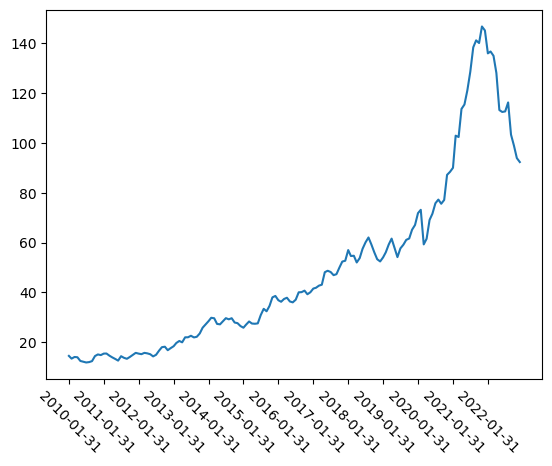

In [13]:
#Plot data to check seasonality of series -- looks at trends per years
plt.plot(df)
plt.xticks(df.index[::12], rotation=-45)
plt.show()  


In [14]:
from statsmodels.tsa.stattools import adfuller

#Apply the Augmented Dickey-Fuller test to check seasonality -- a higher p value means the series is not stationary, therefore it is seasonal
adf = adfuller(df['Close'].dropna())
output = pd.Series(adf[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf[4].items():
    output[f'Critical Value ({key})'] = value

print(output)

Test Statistic                  0.85325
p-value                         0.99245
#Lags Used                     13.00000
Number of Observations Used   142.00000
Critical Value (1%)            -3.47726
Critical Value (5%)            -2.88212
Critical Value (10%)           -2.57774
dtype: float64


#### Decompose and Difference Data

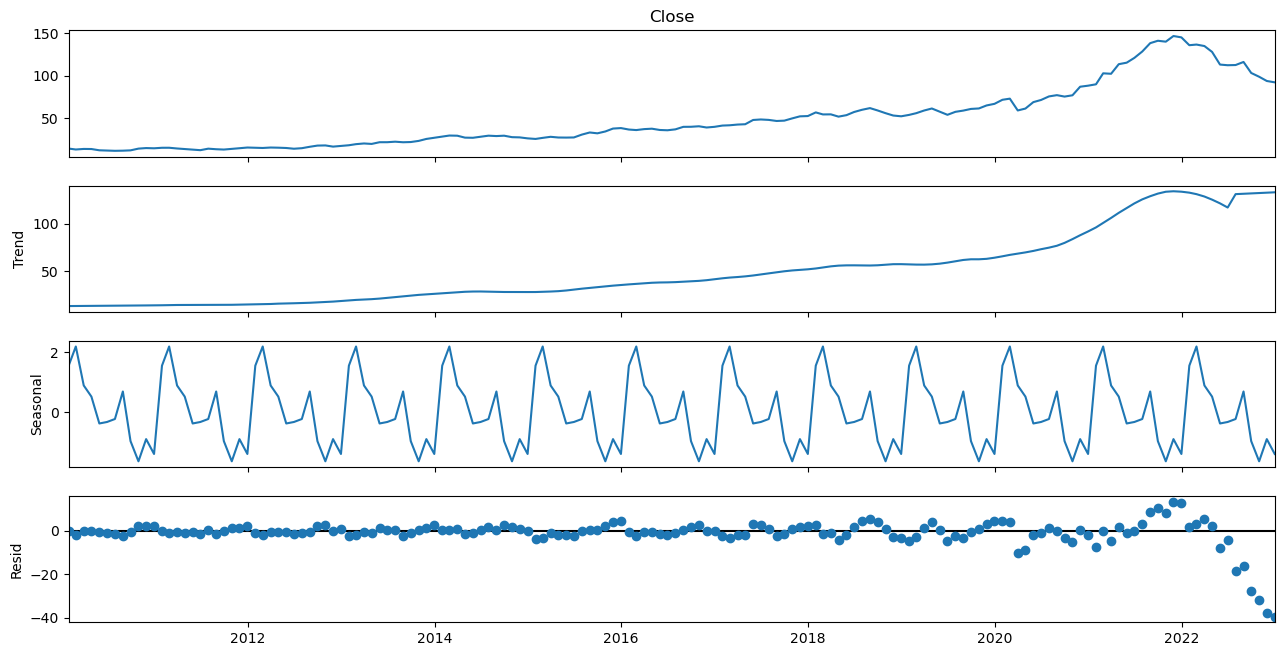

In [15]:
decomposition = sm.tsa.seasonal_decompose(df['Close'], model='additive', extrapolate_trend=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()

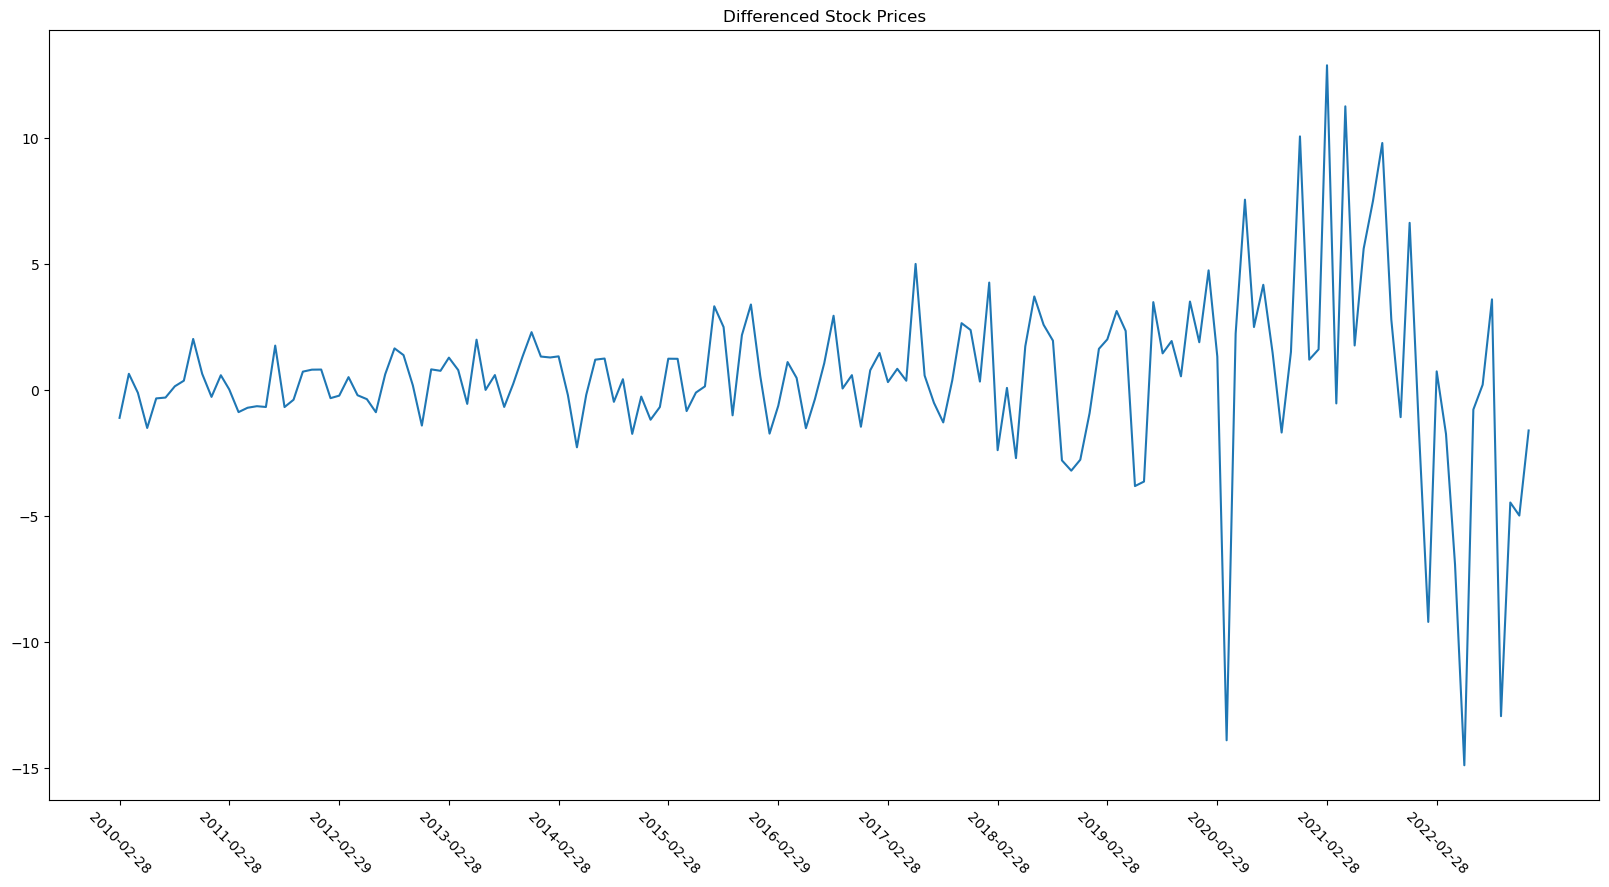

In [16]:
#Difference the series
general_diff = df.diff().dropna()

#Plot the differenced data
plt.figure(figsize=(20, 10))
plt.plot(general_diff)
plt.title('Differenced Stock Prices')
plt.xticks(general_diff.index[::12], rotation=-45)
plt.show()

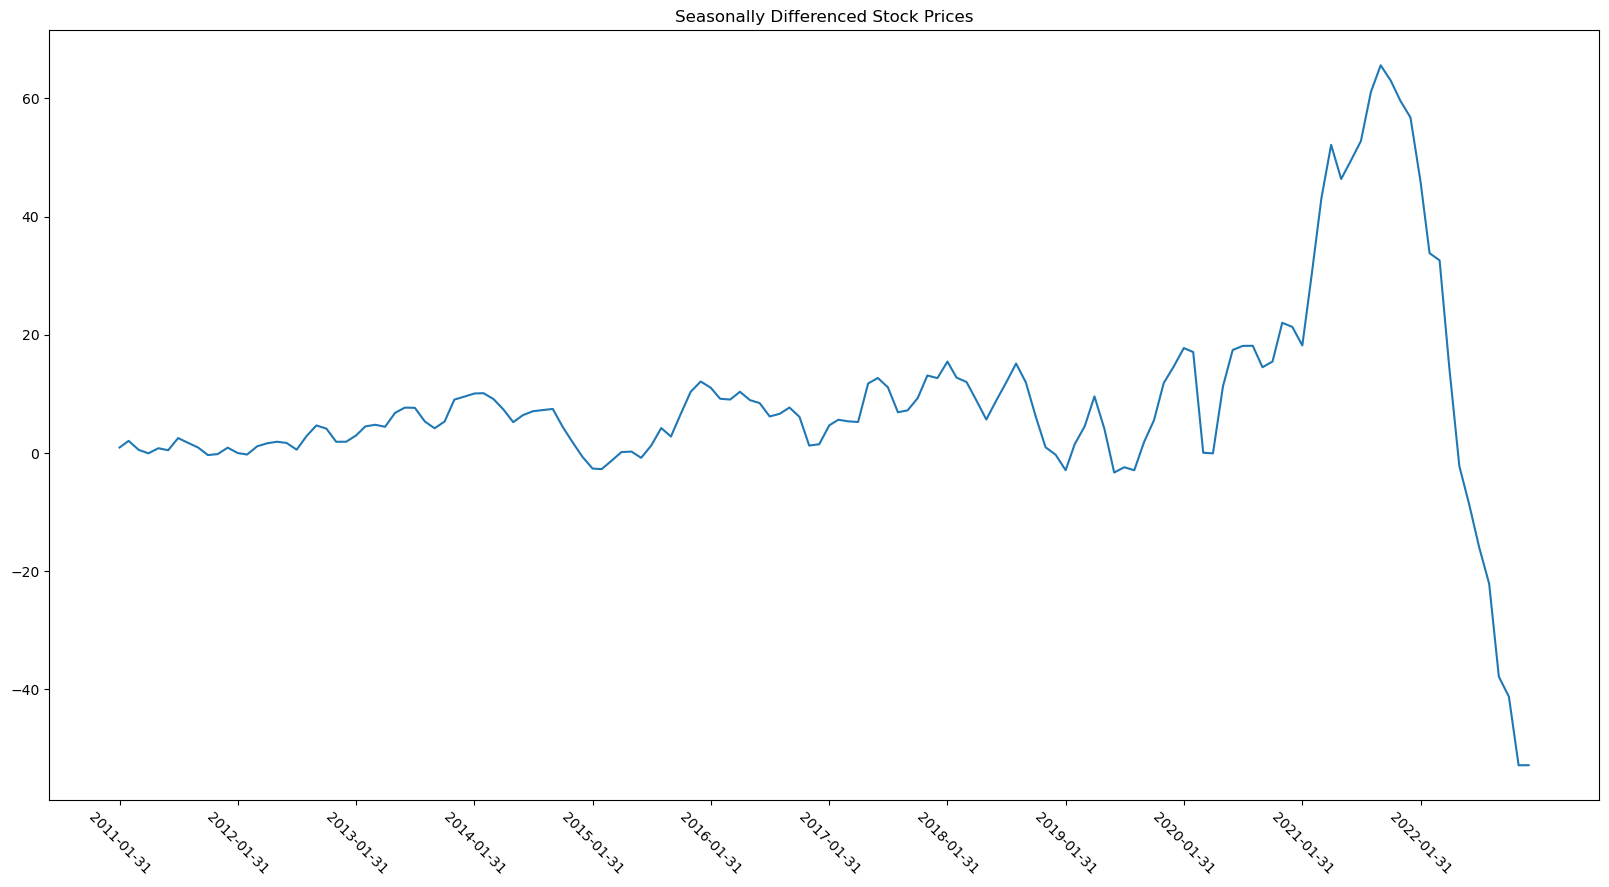

In [17]:
seasonal_diff = df.diff(12).dropna()

#Plot seasonally differenced series
plt.figure(figsize=(20, 10))
plt.plot(seasonal_diff)
plt.title('Seasonally Differenced Stock Prices')
plt.xticks(seasonal_diff.index[::12], rotation=-45)
plt.show()

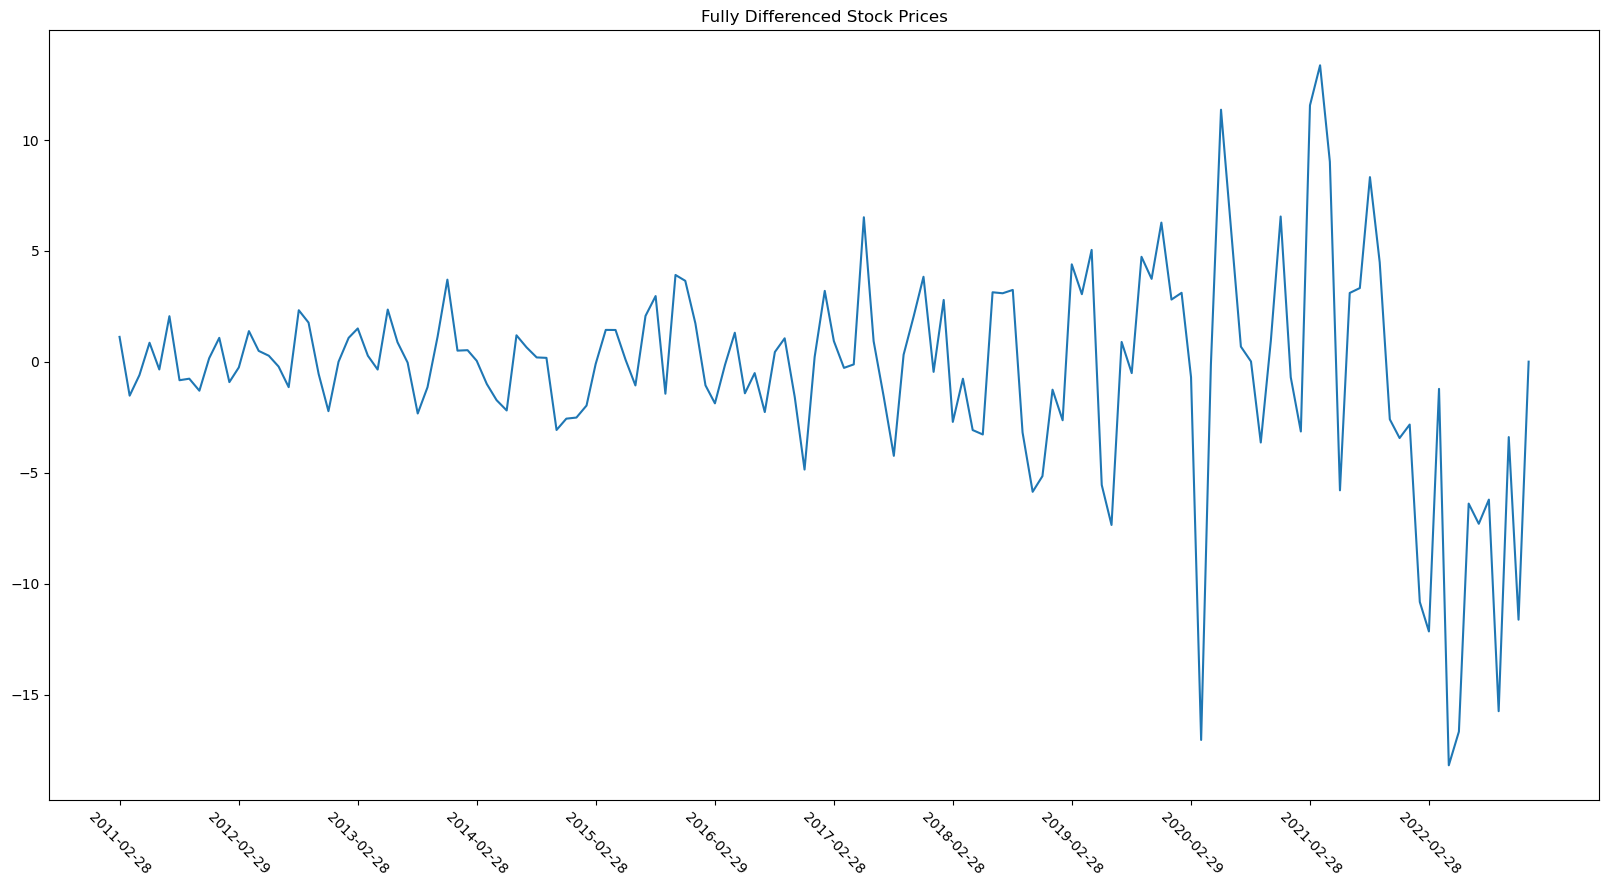

In [18]:
#Calculate and plot full differences (both)
full_diff = general_diff.diff(12).dropna()

plt.figure(figsize=(20, 10))
plt.plot(full_diff)
plt.title('Fully Differenced Stock Prices')
plt.xticks(full_diff.index[::12], rotation=-45)
plt.show()

In [19]:
from statsmodels.tsa.stattools import adfuller
#Apply the Augmented Dickey-Fuller test
adf = adfuller(full_diff)

output = pd.Series(adf[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf[4].items():
    output[f'Critical Value ({key})'] = value

print(output)

Test Statistic                 -5.80207
p-value                         0.00000
#Lags Used                     13.00000
Number of Observations Used   129.00000
Critical Value (1%)            -3.48209
Critical Value (5%)            -2.88422
Critical Value (10%)           -2.57886
dtype: float64


<Figure size 1200x600 with 0 Axes>

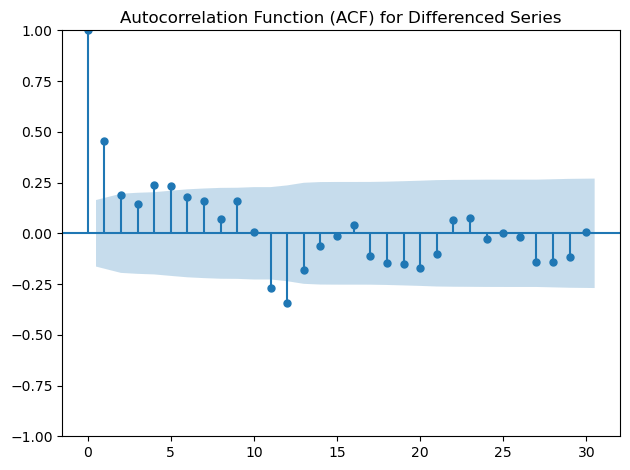

<Figure size 1200x600 with 0 Axes>

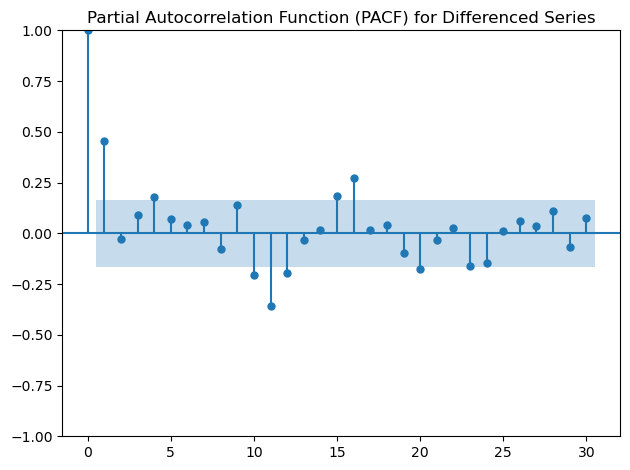

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Plot Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(full_diff, lags=30, alpha=0.05, title='Autocorrelation Function (ACF) for Differenced Series')
plt.tight_layout()

#Plot Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(full_diff, lags=30, alpha=0.05, title='Partial Autocorrelation Function (PACF) for Differenced Series')
plt.tight_layout()

plt.show()

### Find and Fit Optimal Model

In [21]:
#Define series
series = df['Close']

#Find Optimal Model
auto_model = auto_arima(series,
                        start_p=0, start_q=0,
                        max_p=20, max_q=20, 
                        m=12, 
                        start_P=0, start_Q=0, 
                        max_P=20, max_Q=20,
                        seasonal=True,  
                        D=1,  
                        test='adf', 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=856.285, Time=0.03 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=835.724, Time=0.09 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=780.329, Time=0.21 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=824.610, Time=0.04 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=782.329, Time=0.24 sec
 ARIMA(0,2,1)(0,1,2)[12]             : AIC=782.328, Time=0.39 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=800.117, Time=0.10 sec
 ARIMA(0,2,1)(1,1,2)[12]             : AIC=784.274, Time=0.78 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=837.479, Time=0.11 sec
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=782.044, Time=0.32 sec
 ARIMA(0,2,2)(0,1,1)[12]             : AIC=781.916, Time=0.24 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=816.549, Time=0.17 sec
 ARIMA(1,2,2)(0,1,1)[12]             : AIC=783.652, Time=0.46 sec
 ARIMA(0,2,1)(0,1,1)[12] intercept   : AIC=781.522, Time=0.34 sec

Best model:  ARIMA(0,2,1)(0,1,1)

In [22]:
#Get order
order = auto_model.order

#Get seasonal order
seasonal_order = auto_model.seasonal_order

print(f"Non-seasonal order: {order}")
print(f"Seasonal order: {seasonal_order}")

Non-seasonal order: (0, 2, 1)
Seasonal order: (0, 1, 1, 12)


In [23]:
#Split data into training and testing sets
train_size = int(len(series) * 0.8)
series_train, series_test = series[:train_size], series[train_size:]

history = series_train.values.copy()

#Initalize empty lists for predictions and confidence intervals
predictions = []
confidence_intervals = []

#Rolling forecast origin
for t in trange(len(series_test)):
    #Fit SARIMA model
    model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    
    #Forecast next step and calculate confidence interval
    forecast_result = model_fit.get_forecast(steps=1)
    yhat = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=0.05)  # 95% confidence interval
    
    predictions.append(yhat[0]) 
    confidence_intervals.append(conf_int[0])  
    
    actual_obs = series_test.iloc[t]
    history = np.append(history, actual_obs)

100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


Test RMSE: 6.22626230965116


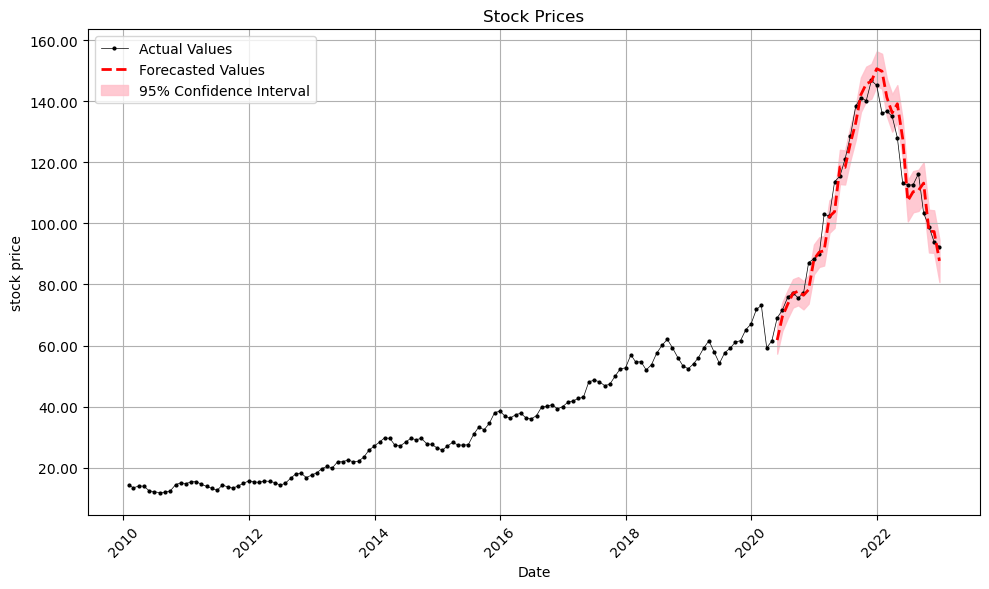

In [24]:
#Calculate RMSE
rmse = np.sqrt(np.mean((predictions - series_test)**2))
print(f'Test RMSE: {rmse}')

#Plotting forecasts, orginal series and confidence interval
plt.figure(figsize=(10, 6))
plt.plot(series.index, series, marker='o', linestyle='-', color='black', markersize=2, linewidth=0.5, label='Actual Values')
plt.plot(series_test.index, predictions, label='Forecasted Values', color='red', linestyle='--', linewidth=2)

#Extract and plot confidence interval bounds
lower_bounds = [ci[0] for ci in confidence_intervals]
upper_bounds = [ci[1] for ci in confidence_intervals]
plt.fill_between(series_test.index, lower_bounds, upper_bounds, color='pink', alpha=0.85, label='95% Confidence Interval')

plt.title('Stock Prices')
plt.xlabel('Date')
plt.ylabel('stock price')
plt.grid(True)

# Formatting y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))


plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
